# 本次測試的15個模型在tacert文件的RAG能力


In [6]:
embedding_models = [
    "intfloat/multilingual-e5-large",
    "BAAI/bge-m3",
    "intfloat/multilingual-e5-small",
    "intfloat/multilingual-e5-base",
    "nomic-ai/nomic-embed-text-v2-moe",
    "infgrad/stella-base-zh-v2",
    "chuxin-llm/Chuxin-Embedding",
    "infgrad/stella-large-zh-v2",
    "BAAI/bge-base-zh-v1.5",
    "infgrad/stella-mrl-large-zh-v3.5-1792d",
    "BAAI/bge-small-zh-v1.5",
    "maidalun1020/bce-embedding-base_v1",
    "aspire/acge_text_embedding",
    "JinaAI/jina-embeddings-v2-base-zh",
    "BAAI/bge-large-zh-v1.5"
]

In [7]:

from sentence_transformers import SentenceTransformer
import fitz
import numpy as np
import os
import faiss
import json


def read_pdf(pdf_path):
    """讀取 PDF 檔案並依據文本頁數返回其內容"""
    page_content= []
    doc = fitz.open(pdf_path)
    for page_num, page in enumerate(doc):
        text = page.get_text()
        page_content.append({'page':page_num+1,'content':text})
    doc.close()
    return page_content


def chunk_text(pages, chunk_size, embed_model):
    """將文本拆分為指定大小的 chunks，允許 chunk 跨越頁數，並標記 chunk 涉及的頁數範圍"""
    chunks = []
    current_chunk = []
    current_pages = set()
    current_length = 0
    max_token_length = chunk_size # 確保 chunk_size 不超過 512

    for page in pages:
        text = page['content']
        text_tokens = embed_model.tokenizer.tokenize(text)

        while text_tokens:
            space_left = max_token_length - current_length

            # 如果當前 chunk 還有空間
            if space_left > 0:
                tokens_to_add = text_tokens[:space_left]
                text_tokens = text_tokens[space_left:]

                current_chunk.extend(tokens_to_add)
                current_pages.add(page['page'])
                current_length += len(tokens_to_add)

            # 當 chunk 滿了，就存入 chunks，並重置變數
            if current_length >= max_token_length or (current_length > 0 and len(text_tokens) > 0):
                chunks.append({
                    'pages': sorted(current_pages),
                    'content': embed_model.tokenizer.convert_tokens_to_string(current_chunk)
                })
                current_chunk = []
                current_pages = set()
                current_length = 0

    # 處理最後一個未滿的 chunk
    if current_length > 0:
        chunks.append({
            'pages': sorted(current_pages),
            'content': embed_model.tokenizer.convert_tokens_to_string(current_chunk)
        })

    return chunks


def search_faiss(query_text, embed_model,index,faiss_metadata,top_k=2):
    """搜尋最相近的前 top_k 筆資料"""
    query_embedding = embed_model.encode(query_text).astype(np.float32)
    query_embedding = np.expand_dims(query_embedding, axis=0)  # FAISS 需要 2D 陣列

    # **🚀 查詢 FAISS**
    _, indices = index.search(query_embedding, top_k)

    results = []
    for idx in indices[0]:
        if str(idx) in faiss_metadata:
            results.append(faiss_metadata[str(idx)])

    return results


In [8]:
folder_path = '../pdf'
pdf_files = [f for f in os.listdir(folder_path) if f.lower().endswith('.pdf')]


# 比較模型性能

In [9]:
model_performance = []
for model_name in embedding_models:
    files_to_delete = ['faiss_metadata.json', 'faiss_index.idx']
    for file in files_to_delete:
        if os.path.exists(file):
            os.remove(file)
    embed_model = SentenceTransformer(model_name ,trust_remote_code=True)
    faiss_metadata = {}
    EMBEDDING_DIM = embed_model.get_sentence_embedding_dimension()
    index = faiss.IndexFlatL2(EMBEDDING_DIM)  # L2 距離索引
    chunk_sizes = [512]  # 測試不同 chunk sizes
    for pdf_file in pdf_files:
        full_path = os.path.join(folder_path, pdf_file)
        content = read_pdf(full_path)
        for size in chunk_sizes:
            chunks = chunk_text(content, size,embed_model)

            for idx, chunk in enumerate(chunks):
                text = chunk["content"]
                # **🚀 計算 embedding 並存入 cache**
                embedding = embed_model.encode(text).astype(np.float32)
                # **🚀 儲存 metadata**
                data = {
                    "File_Name": pdf_file,
                    "content": text,
                    "Page_Num": ','.join(str(p) for p in chunk["pages"])
                }
                index.add(np.array([embedding]))  # 加入 FAISS
                faiss_metadata[len(faiss_metadata)] = data  # FAISS ID 對應 metadata

    # **🚀 儲存 FAISS 索引**
    faiss.write_index(index, "faiss_index.idx")
    with open("faiss_metadata.json", "w", encoding="utf-8") as f:
        json.dump(faiss_metadata, f, ensure_ascii=False, indent=4)

    print(f"已儲存 {len(faiss_metadata)} 筆資料到 FAISS")
    
    with open("faiss_metadata.json", "r", encoding="utf-8") as f:
        faiss_metadata = json.load(f)
    with open('pdf_questions.json', 'r', encoding='utf-8') as f:
        pdf_questions = json.load(f)
    index = faiss.read_index("faiss_index.idx")

    win = 0
    loss = 0
    MRR = 0

    for query in pdf_questions:
        results = search_faiss(query['question'], embed_model,index,faiss_metadata,top_k=3)
        find = False
        for idx, metadata in enumerate(results):
            if metadata['File_Name'] == query['File_Name'] and str(query['Page_Num']) in  metadata['Page_Num']:
                find = True
                win += 1
                MRR += 1/(idx+1)
                break
        if not find:
            loss += 1
    del embed_model
    model_performance.append({'model':model_name,'win':win,'loss':loss,'MRR':MRR/len(pdf_questions)})


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


已儲存 36 筆資料到 FAISS
已儲存 36 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


已儲存 36 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


已儲存 36 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (540 > 512). Running this sequence through the model will result in indexing errors


已儲存 36 筆資料到 FAISS


No sentence-transformers model found with name infgrad/stella-base-zh-v2. Creating a new one with mean pooling.
Token indices sequence length is longer than the specified maximum sequence length for this model (2542 > 1024). Running this sequence through the model will result in indexing errors


已儲存 47 筆資料到 FAISS
已儲存 36 筆資料到 FAISS


No sentence-transformers model found with name infgrad/stella-large-zh-v2. Creating a new one with mean pooling.
Token indices sequence length is longer than the specified maximum sequence length for this model (2542 > 1024). Running this sequence through the model will result in indexing errors


已儲存 47 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


已儲存 47 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


已儲存 47 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


已儲存 46 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (541 > 512). Running this sequence through the model will result in indexing errors


已儲存 36 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (2542 > 1024). Running this sequence through the model will result in indexing errors


已儲存 47 筆資料到 FAISS
已儲存 36 筆資料到 FAISS


Token indices sequence length is longer than the specified maximum sequence length for this model (513 > 512). Running this sequence through the model will result in indexing errors


已儲存 47 筆資料到 FAISS


前五名的準確度:
                              model  accuracy       MRR
1                       BAAI/bge-m3  0.880597  0.761194
5         infgrad/stella-base-zh-v2  0.858209  0.726368
3     intfloat/multilingual-e5-base  0.850746  0.700249
7        infgrad/stella-large-zh-v2  0.843284  0.725124
4  nomic-ai/nomic-embed-text-v2-moe  0.843284  0.706468


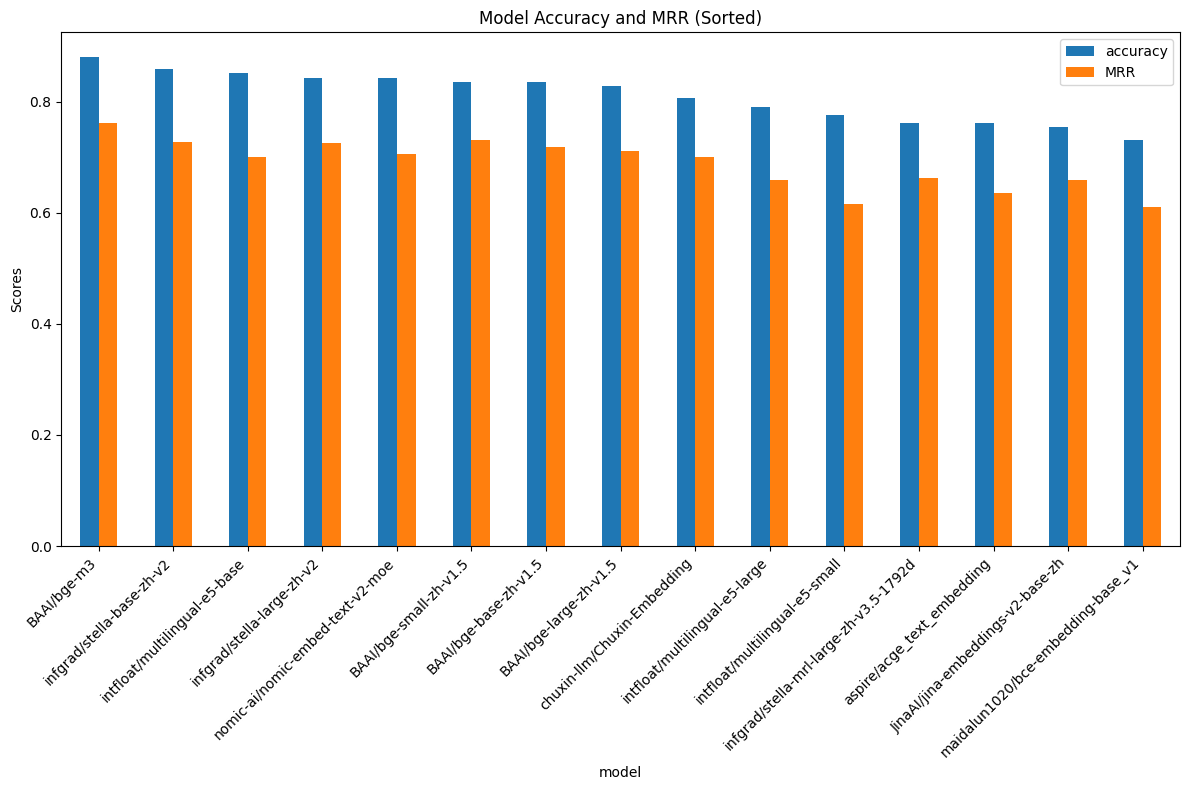

In [11]:
import pandas as pd

import matplotlib.pyplot as plt


df = pd.DataFrame(model_performance)

# Calculate accuracy
df['accuracy'] = df['win'] / (df['win'] + df['loss'])

# Sort the DataFrame by accuracy and MRR in descending order
df = df.sort_values(by=['accuracy', 'MRR'], ascending=False)

# Plot both accuracy and MRR on the same chart
ax = df.plot(kind='bar', x='model', y=['accuracy', 'MRR'], figsize=(12, 8))
ax.set_title('Model Accuracy and MRR (Sorted)')
ax.set_xticklabels(df['model'], rotation=45, ha='right')
ax.set_ylabel('Scores')


plt.tight_layout()


top5 = df.head(5)
print("前五名的準確度:")
print(top5[['model', 'accuracy', 'MRR']])